# Unsupervised Pre-training:

In [1]:
from PIL import Image
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
import seaborn as sns

2023-12-05 14:01:48.809063: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train_ds = 'train/'
len(os.listdir(train_ds))

71056

### Base datasets and training

In [3]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:25000]:
  try:
    img = Image.open(train_ds + f"{file}")
    if np.asarray(img).shape == (200, 200, 3):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [4]:
train = np.array(train)
train.shape

(24880, 200, 200, 3)

In [5]:
train = train.astype('float32') / 255.0

In [6]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]
print(len(train))

19904


In [9]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Rescaling(1.0/255, input_shape=(200, 200, 3)),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size = 1),
    keras.layers.Conv2D(256, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(256, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(512, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D()
])
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[50, 50, 512]),
    keras.layers.Conv2DTranspose(256, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),

    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=2, padding="same", activation="sigmoid",
                        ),
    keras.layers.Reshape([200, 200, 3])
])

2023-12-05 12:24:26.201768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38111 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:07:00.0, compute capability: 8.0
2023-12-05 12:24:26.206417: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38111 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:0f:00.0, compute capability: 8.0
2023-12-05 12:24:26.208036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38111 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:47:00.0, compute capability: 8.0
2023-12-05 12:24:26.209628: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 38111 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-40GB, pci bu

In [10]:
def rounded_accuracy(y_true, y_pred):
    retudef rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))rn keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [11]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0001), #tried Adam and lr = 0.0001 -> 89%
                    metrics = rounded_accuracy)

In [12]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 5)

Epoch 1/5


2023-12-05 12:24:43.531941: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-05 12:24:51.926383: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5984f038c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 12:24:51.926433: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-05 12:24:51.926439: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-05 12:24:51.926443: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-05 12:24:51.926446: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-05 12:24:51.997099: I tensorflow/compiler/mlir/tensorflow/utils/dump_

622/622 [==============================] - 221s 310ms/step - loss: 0.5196 - rounded_accuracy: 0.9383 - val_loss: 0.5084 - val_rounded_accuracy: 0.9583
Epoch 2/5
622/622 [==============================] - 154s 247ms/step - loss: 0.5078 - rounded_accuracy: 0.9610 - val_loss: 0.5059 - val_rounded_accuracy: 0.9649
Epoch 3/5
622/622 [==============================] - 152s 244ms/step - loss: 0.5063 - rounded_accuracy: 0.9647 - val_loss: 0.5050 - val_rounded_accuracy: 0.9673
Epoch 4/5
622/622 [==============================] - 151s 242ms/step - loss: 0.5050 - rounded_accuracy: 0.9698 - val_loss: 0.5029 - val_rounded_accuracy: 0.9752
Epoch 5/5
622/622 [==============================] - 151s 242ms/step - loss: 0.5033 - rounded_accuracy: 0.9772 - val_loss: 0.5024 - val_rounded_accuracy: 0.9778


In [13]:
autoencoder.layers[0].layers

In [14]:
len(autoencoder.weights)

24

In [15]:
model = keras.models.Sequential([
    layer for layer in autoencoder.layers[0].layers
])

In [16]:
for layer in model.layers:
    layer.trainable = False

In [17]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='selu'))
model.add(keras.layers.Dense(64, activation='selu'))
model.add(keras.layers.Dense(8, activation = 'softmax'))

In [18]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 128)     3584      
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 128)     147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 200, 200, 128)     147584    
                                                                 
 max_pooling2d (MaxPooling2  (None, 200, 200, 128)     0         
 D)                                                              
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 256)     295168    
                                                      

In [19]:
affectnet_train = keras.utils.image_dataset_from_directory(
    directory = 'affectnet/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (200, 200),
    batch_size = 32,
    validation_split = 0.8,
    subset = 'training',
    seed = 42
)

Found 29042 files belonging to 8 classes.
Using 5809 files for training.


In [20]:
affectnet_val = keras.utils.image_dataset_from_directory(
    directory = 'affectnet/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (200, 200),
    batch_size = 32,
    validation_split = 0.8,
    subset = 'validation',
    seed = 42
)

Found 29042 files belonging to 8 classes.
Using 23233 files for validation.


In [21]:
model.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00005),
                    metrics = 'accuracy')

In [24]:
model.fit(affectnet_train, validation_data = affectnet_val,
                epochs = 5)

Epoch 1/5


2023-12-05 12:41:42.179488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


182/182 [==============================] - 79s 351ms/step - loss: 61.5291 - accuracy: 0.1749 - val_loss: 30.7453 - val_accuracy: 0.1680
Epoch 2/5
182/182 [==============================] - 56s 306ms/step - loss: 23.0770 - accuracy: 0.2419 - val_loss: 21.9126 - val_accuracy: 0.3262
Epoch 3/5
182/182 [==============================] - 55s 306ms/step - loss: 18.6039 - accuracy: 0.2908 - val_loss: 15.5520 - val_accuracy: 0.2744
Epoch 4/5
182/182 [==============================] - 55s 305ms/step - loss: 19.1553 - accuracy: 0.2997 - val_loss: 12.0080 - val_accuracy: 0.3441
Epoch 5/5
182/182 [==============================] - 55s 303ms/step - loss: 24.1880 - accuracy: 0.3023 - val_loss: 15.3236 - val_accuracy: 0.3431


In [43]:
labels = sorted([folder for folder in os.listdir('affectnet') if '.' not in folder])
labels

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [73]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_predictions(model, images=train, n_images=5):
    predictions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index).set_title(labels[np.argmax(predictions[image_index])])
        plot_image(images[image_index])

1/1 [==============================] - 3s 3s/step


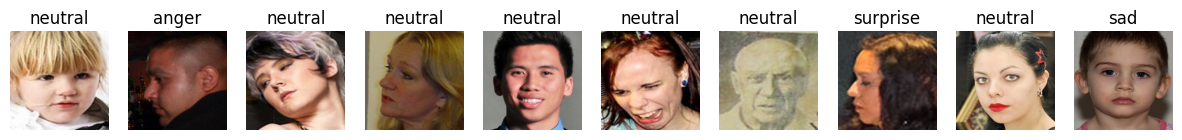

In [75]:
show_predictions(model, images = validation, n_images = 10)

### Grayscale datasets and training

In [3]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:25000]:
  try:
    img = Image.open(train_ds + f"{file}").convert('L')
    if np.asarray(img).shape == (200, 200):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [4]:
train = np.array(train)
train.shape

(25000, 200, 200)

In [5]:
train = train.astype('float32') / 255.0

In [6]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]

print(len(train))

20000


In [13]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Rescaling(1.0/255, input_shape=(200, 200, 1)),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size = 1),
    keras.layers.Conv2D(256, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(256, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(512, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D()
])
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[50, 50, 512]),
    keras.layers.Conv2DTranspose(256, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),

    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid",
                        ),
    keras.layers.Reshape([200, 200, 1])
])

In [14]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [15]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0001), #tried Adam and lr = 0.0001 -> 89%
                    metrics = rounded_accuracy)

In [16]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 5)

Epoch 1/5


2023-12-05 13:28:21.219377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2023-12-05 13:28:30.106354: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6a74bfb7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 13:28:30.106403: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-05 13:28:30.106414: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-05 13:28:30.106418: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-05 13:28:30.106422: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-40GB, Compute Capability 8.0
2023-12-05 13:28:30.176392: I tensorflow/compiler/mlir/tensorflow/utils/dump_

625/625 [==============================] - 219s 305ms/step - loss: 0.5348 - rounded_accuracy: 0.9529 - val_loss: 0.5274 - val_rounded_accuracy: 0.9697
Epoch 2/5
625/625 [==============================] - 150s 241ms/step - loss: 0.5267 - rounded_accuracy: 0.9712 - val_loss: 0.5269 - val_rounded_accuracy: 0.9604
Epoch 3/5
625/625 [==============================] - 149s 238ms/step - loss: 0.5256 - rounded_accuracy: 0.9750 - val_loss: 0.5250 - val_rounded_accuracy: 0.9799
Epoch 4/5
625/625 [==============================] - 149s 239ms/step - loss: 0.5250 - rounded_accuracy: 0.9788 - val_loss: 0.5246 - val_rounded_accuracy: 0.9803
Epoch 5/5
625/625 [==============================] - 149s 238ms/step - loss: 0.5246 - rounded_accuracy: 0.9811 - val_loss: 0.5242 - val_rounded_accuracy: 0.9831


In [17]:
autoencoder.layers[0].layers

In [18]:
len(autoencoder.weights)

24

In [19]:
model = keras.models.Sequential([
    layer for layer in autoencoder.layers[0].layers
])

In [20]:
for layer in model.layers:
    layer.trainable = False

In [21]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='selu'))
model.add(keras.layers.Dense(64, activation='selu'))
model.add(keras.layers.Dense(8, activation = 'softmax'))

In [22]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 1)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 200, 200, 128)     1280      
                                                                 
 conv2d_7 (Conv2D)           (None, 200, 200, 128)     147584    
                                                                 
 conv2d_8 (Conv2D)           (None, 200, 200, 128)     147584    
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 200, 200, 128)     0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 200, 200, 256)     295168    
                                                      

In [23]:
affectnet_train = keras.utils.image_dataset_from_directory(
    directory = 'affectnet/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (200, 200),
    batch_size = 32,
    validation_split = 0.8,
    subset = 'training',
    color_mode = 'grayscale',
    seed = 42
)

Found 29042 files belonging to 8 classes.
Using 5809 files for training.


In [24]:
affectnet_val = keras.utils.image_dataset_from_directory(
    directory = 'affectnet/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (200, 200),
    batch_size = 32,
    validation_split = 0.8,
    subset = 'validation',
    color_mode = 'grayscale',
    seed = 42
)

Found 29042 files belonging to 8 classes.
Using 23233 files for validation.


In [30]:
model.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005),
                    metrics = 'accuracy')

In [31]:
model.fit(affectnet_train, validation_data = affectnet_val,
                epochs = 5)

Epoch 1/5
182/182 [==============================] - 55s 296ms/step - loss: 4.8058 - accuracy: 0.4855 - val_loss: 5.5937 - val_accuracy: 0.3934
Epoch 2/5
182/182 [==============================] - 54s 296ms/step - loss: 3.4526 - accuracy: 0.5170 - val_loss: 5.2823 - val_accuracy: 0.4085
Epoch 3/5
182/182 [==============================] - 54s 296ms/step - loss: 3.0733 - accuracy: 0.5225 - val_loss: 5.5418 - val_accuracy: 0.3840
Epoch 4/5
182/182 [==============================] - 54s 295ms/step - loss: 2.8591 - accuracy: 0.5448 - val_loss: 4.2421 - val_accuracy: 0.4131
Epoch 5/5
182/182 [==============================] - 54s 295ms/step - loss: 2.8597 - accuracy: 0.5294 - val_loss: 3.4056 - val_accuracy: 0.4358


In [32]:
labels = sorted([folder for folder in os.listdir('affectnet') if '.' not in folder])
labels

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [33]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_predictions(model, images=train, n_images=5):
    predictions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index).set_title(labels[np.argmax(predictions[image_index])])
        plot_image(images[image_index])

1/1 [==============================] - 0s 100ms/step


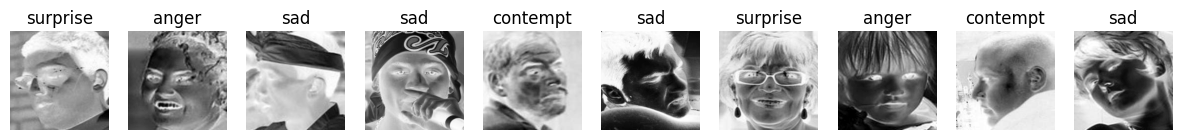

In [34]:
show_predictions(model, images = validation, n_images = 10)

### Cropped datasets and training

In [3]:
train = []
files = [file for file in os.listdir(train_ds) if '.jpg' in file or '.jpeg' in file]
for file in files[:25000]:
  try:
    img = Image.open(train_ds + f"{file}").crop((25, 25, 175, 175))
    if np.asarray(img).shape == (150, 150, 3):
      train.append(np.asarray(img))
  except Exception as e:
    print(e)

In [4]:
train = np.array(train)
train.shape

(24880, 150, 150, 3)

In [5]:
train = train.astype('float32') / 255.0

In [6]:
validation = train[int(len(train) * 0.8):]
train = train[:int(len(train) * 0.8)]

print(len(train))

19904


In [19]:
tf.random.set_seed(42)
np.random.seed(42)

encoder = keras.models.Sequential([
    keras.layers.Rescaling(1.0/255, input_shape=(150, 150, 3)),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(128, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size = 1),
    keras.layers.Conv2D(256, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.Conv2D(256, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size = 1),
    keras.layers.Conv2D(512, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D()
])
decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(256, kernel_size=3, strides=2, padding="SAME", activation="selu",
                                 input_shape=[75, 75, 512]),
    keras.layers.Conv2DTranspose(256, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(128, kernel_size=3, strides=1, padding="SAME", activation="selu"),

    keras.layers.Conv2DTranspose(3, kernel_size=3, strides=1, padding="same", activation="sigmoid",
                        ),
    keras.layers.Reshape([150, 150, 3])
])

In [20]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [21]:
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss = 'binary_crossentropy',
                    optimizer = tf.keras.optimizers.Adamax(learning_rate = 0.0001), #tried Adam and lr = 0.0001 -> 89%
                    metrics = rounded_accuracy)

In [22]:
autoencoder.fit(train, train, validation_data = [validation, validation],
                epochs = 5)

Epoch 1/5


2023-12-05 14:06:53.203683: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55abe70ffc10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-05 14:06:53.203739: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 14:06:53.203747: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 14:06:53.203751: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (2): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 14:06:53.203755: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (3): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-12-05 14:06:53.271104: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-12-05

622/622 [==============================] - 254s 359ms/step - loss: 0.5365 - rounded_accuracy: 0.9555 - val_loss: 0.5310 - val_rounded_accuracy: 0.9693
Epoch 2/5
622/622 [==============================] - 163s 262ms/step - loss: 0.5296 - rounded_accuracy: 0.9754 - val_loss: 0.5286 - val_rounded_accuracy: 0.9791
Epoch 3/5
622/622 [==============================] - 161s 259ms/step - loss: 0.5283 - rounded_accuracy: 0.9816 - val_loss: 0.5279 - val_rounded_accuracy: 0.9853
Epoch 4/5
622/622 [==============================] - 161s 259ms/step - loss: 0.5280 - rounded_accuracy: 0.9829 - val_loss: 0.5278 - val_rounded_accuracy: 0.9848
Epoch 5/5
622/622 [==============================] - 161s 259ms/step - loss: 0.5277 - rounded_accuracy: 0.9848 - val_loss: 0.5274 - val_rounded_accuracy: 0.9889


In [23]:
autoencoder.layers[0].layers

In [24]:
len(autoencoder.weights)

24

In [25]:
model = keras.models.Sequential([
    layer for layer in autoencoder.layers[0].layers
])

In [26]:
for layer in model.layers:
    layer.trainable = False

In [27]:
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='selu'))
model.add(keras.layers.Dense(64, activation='selu'))
model.add(keras.layers.Dense(8, activation = 'softmax'))

In [28]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 150, 150, 128)     3584      
                                                                 
 conv2d_43 (Conv2D)          (None, 150, 150, 128)     147584    
                                                                 
 conv2d_44 (Conv2D)          (None, 150, 150, 128)     147584    
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 150, 150, 128)     0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 150, 150, 256)     295168    
                                                     

In [29]:
affectnet_train = keras.utils.image_dataset_from_directory(
    directory = 'affectnet/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (200, 200),
    batch_size = 32,
    validation_split = 0.8,
    subset = 'training',
    seed = 42
)
affectnet_train = affectnet_train.map(lambda x, y: (tf.image.crop_to_bounding_box(x, 25, 25, 150, 150), y))

Found 29042 files belonging to 8 classes.
Using 5809 files for training.


In [30]:
affectnet_val = keras.utils.image_dataset_from_directory(
    directory = 'affectnet/',
    labels = 'inferred',
    label_mode = 'categorical',
    image_size = (200, 200),
    batch_size = 32,
    validation_split = 0.8,
    subset = 'validation',
    seed = 42
)
affectnet_val = affectnet_val.map(lambda x, y: (tf.image.crop_to_bounding_box(x, 25, 25, 150, 150), y))

Found 29042 files belonging to 8 classes.
Using 23233 files for validation.


In [31]:
model.compile(loss = 'categorical_crossentropy',
                    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.000005),
                    metrics = 'accuracy')

In [32]:
model.fit(affectnet_train, validation_data = affectnet_val,
                epochs = 5)

Epoch 1/5


2023-12-05 14:21:58.034159: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


182/182 [==============================] - 71s 309ms/step - loss: 5.6497 - accuracy: 0.2317 - val_loss: 2.2998 - val_accuracy: 0.2960
Epoch 2/5
182/182 [==============================] - 48s 264ms/step - loss: 2.8367 - accuracy: 0.3333 - val_loss: 4.0343 - val_accuracy: 0.2778
Epoch 3/5
182/182 [==============================] - 48s 264ms/step - loss: 2.3519 - accuracy: 0.3891 - val_loss: 3.0922 - val_accuracy: 0.3875
Epoch 4/5
182/182 [==============================] - 48s 264ms/step - loss: 2.5383 - accuracy: 0.3997 - val_loss: 2.5950 - val_accuracy: 0.3276
Epoch 5/5
182/182 [==============================] - 48s 264ms/step - loss: 2.1378 - accuracy: 0.4266 - val_loss: 2.1949 - val_accuracy: 0.4150


In [33]:
labels = sorted([folder for folder in os.listdir('affectnet') if '.' not in folder])
labels

['anger', 'contempt', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

In [34]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_predictions(model, images=train, n_images=5):
    predictions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index).set_title(labels[np.argmax(predictions[image_index])])
        plot_image(images[image_index])

1/1 [==============================] - 4s 4s/step


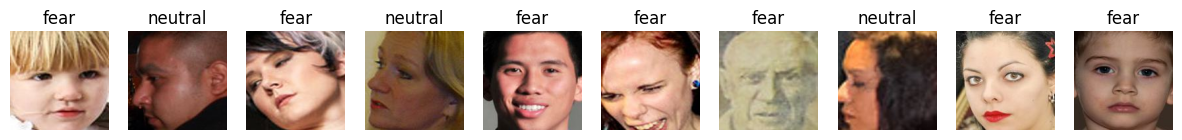

In [35]:
show_predictions(model, images = validation, n_images = 10)